# Example: Simplify and Redensify a Watershed



<b> In the simplification step below, we keep the original river so that we can sample vertices from these original dense rivers and huc boundaries to get vertex density at desired resolution. </b>

Using the Douglas-Peucker algorithm, we simplify the flowline by removing non-essential vertices with shapely's "simplify" method, ensuring accurate representation. Additional simplifications, such as merging minor reaches and aligning watershed boundaries with flowlines, are also performed. The process is demonstrated in the figure below:

![Optional Alt Text](../images/densification.png)

TIPS:
- keep merge tolerance about 70% of the simplify_rivers tolerance
- use smaller snap tolerance 50% of simplify_rivers if non-outlet reaches start snapping to the watershed boundaries

In [15]:
%matplotlib widget

In [11]:
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import copy
import shapely
import pickle
import ipympl

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.crs
import watershed_workflow.densification
watershed_workflow.ui.setup_logging(1,None)


In [3]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = '../../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'

figsize = (6,6)
figsize_3d = (8,6)


In [4]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

### Sources and setup

In [5]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']

sources

{'HUC': <watershed_workflow.sources.manager_nhd_accumulator.FileManagerNHDPlusAccumulator at 0x7fffcb0e8eb0>,
 'hydrography': FileManagerNHDPlus(name='National Hydrography Dataset Plus High Resolution (NHDPlus HR)', file_level=4, lowest_level=12, name_manager=Names(name='National Hydrography Dataset Plus High Resolution (NHDPlus HR)', base_folder='hydrography', folder_template='NHDPlus_H_{}_GDB', file_template='NHDPlus_H_{}.gdb', raw_template=None)),
 'DEM': <watershed_workflow.sources.manager_ned.FileManagerNED at 0x7fffcaa335b0>,
 'soil structure': <watershed_workflow.sources.manager_nrcs.FileManagerNRCS at 0x7fffcaa33b20>,
 'geologic structure': FileManagerGLHYMPS(_filename='/home/jovyan/workdir/notebooks/module2/data/soil_structure/GLHYMPS/GLHYMPS.shp'),
 'land cover': <watershed_workflow.sources.manager_nlcd.FileManagerNLCD at 0x7fffcaa331c0>,
 'lai': <watershed_workflow.sources.manager_modis_appeears.FileManagerMODISAppEEARS at 0x7fffcaa32860>,
 'depth to bedrock': FileManagerPel

### Get HUCs

In [6]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-11-15 01:28:18,077 - root - INFO: 
2024-11-15 01:28:18,080 - root - INFO: Loading shapes
2024-11-15 01:28:18,082 - root - INFO: ------------------------------
2024-11-15 01:28:18,083 - root - INFO: Loading file: '../../Coweeta_data/input_data/coweeta_basin.shp'
2024-11-15 01:28:18,137 - root - INFO: ... found 1 shapes
2024-11-15 01:28:18,137 - root - INFO: Converting to shapely
2024-11-15 01:28:18,142 - root - INFO:  ... done
2024-11-15 01:28:18,145 - root - INFO: Converting to requested CRS
2024-11-15 01:28:18,173 - root - INFO:  ... done
2024-11-15 01:28:18,173 - root - INFO: Removing holes on 1 polygons
2024-11-15 01:28:18,174 - root - INFO:   -- removed interior
2024-11-15 01:28:18,177 - root - INFO:   -- union
2024-11-15 01:28:18,178 - root - INFO: Parsing 1 components for holes
2024-11-15 01:28:18,178 - root - INFO:   -- complete


### Get Rivers 

In [7]:
# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# download/collect the river network within that shape's bounds
# _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
#                                             watershed.exterior(), crs, crs,
#                                             in_network=True, properties=True)

with open('../../Coweeta_data/input_data/hydrography/reaches.pkl', 'rb') as fid:
    reaches_with_properties = pickle.load(fid)
    reaches = []
    for reach, props in reaches_with_properties:
        line = shapely.geometry.LineString(reach)
        line.properties = props
        reaches.append(line)        

rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                remove_diversions=True,
                                                remove_braided_divergences=True)

2024-11-15 01:28:20,064 - root - INFO: 
2024-11-15 01:28:20,067 - root - INFO: Constructing river network
2024-11-15 01:28:20,068 - root - INFO: ------------------------------
2024-11-15 01:28:20,068 - root - INFO: Generating the river tree
2024-11-15 01:28:20,069 - root - INFO:  ... generated 1 rivers
2024-11-15 01:28:20,069 - root - INFO: Removing rivers with fewer than 2 reaches.
2024-11-15 01:28:20,070 - root - INFO: ... removed 0 rivers
2024-11-15 01:28:20,071 - root - INFO: Removing rivers with area < 0.15077295398495122
2024-11-15 01:28:20,071 - root - INFO: Removing divergent sections...
2024-11-15 01:28:20,072 - root - INFO:   ... removed 0 divergence tributaries with 0 total reaches.
2024-11-15 01:28:20,073 - root - INFO: Pruning by total contributing area < 0.15077295398495122
2024-11-15 01:28:20,073 - root - INFO: ... pruned 0
2024-11-15 01:28:20,074 - root - INFO: Removing rivers with fewer than 2 reaches.
2024-11-15 01:28:20,074 - root - INFO: ... removed 0 rivers


### Simplify

for using new method for densification, use simplify length scale as 1m

In [8]:
simplify = 70 # length scale to target average edge, ; set this as 1 or 2 when using new densify 
snap_tol = 40
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            snap_tol=snap_tol, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-15 01:28:23,116 - root - INFO: 
2024-11-15 01:28:23,117 - root - INFO: Simplifying
2024-11-15 01:28:23,118 - root - INFO: ------------------------------
2024-11-15 01:28:23,119 - root - INFO: Simplifying rivers
2024-11-15 01:28:23,128 - root - INFO: Simplifying HUCs
2024-11-15 01:28:23,129 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-15 01:28:23,131 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-15 01:28:23,144 - root - INFO:   snapping river endpoints to the polygon
2024-11-15 01:28:23,155 - root - INFO:   cutting at crossings
2024-11-15 01:28:23,159 - root - INFO: intersection found
2024-11-15 01:28:23,168 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-15 01:28:23,169 - root - INFO:       split HUC boundary seg into 2 pieces
2024-11-15 01:28:23,169 - root - INFO:       split reach seg into 2 pieces
2024-11-15 01:28:23,179 - root - INFO: Cutting crossings and removing external segments
2024-11-

Plotting original and simplified-pruned rivers and watershed


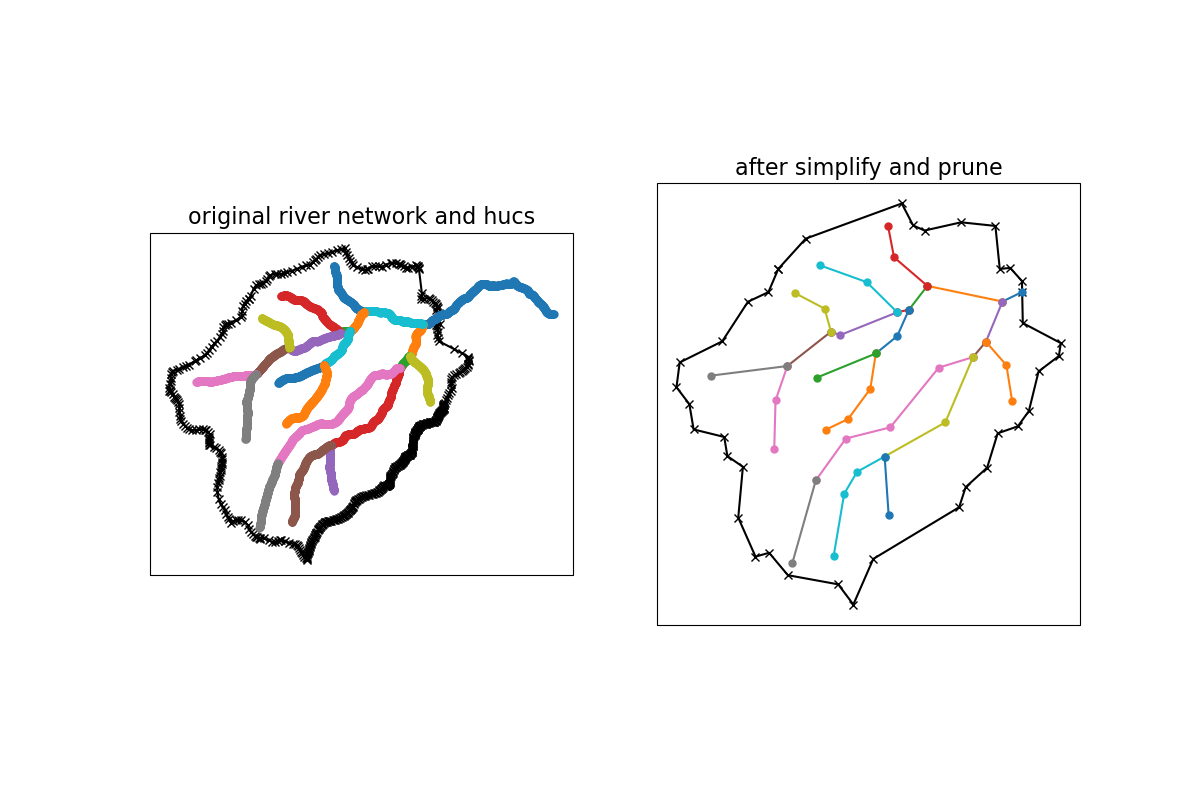

In [16]:
fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(12,8))

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

### Densification of River Network and Watershed

<b>In step two, we enhance the flowline and watershed boundary resolution by adding nearly uniformly distributed vertices, sampled from the original to regain any curvature lost during simplification. </b> 

User provides an upper limit that dictates the distance between two consecutive vertices on the reach segment and ultimately determine the quad length in the river mesh. When this distance in a reach segment, represented as a `shapely.LineString` object, exceeds this scale, additional vertices are inserted. Their number and coordinates are derived using 1D interpolation from the original segment vertices. 


The limit on the distance between vertices on the huc boundary is a function of distance from the river. Parts of huc segments close to river get vertices placed at higher density. 

TIPS:

- provide L0 about same as length scale limit on river and  L1 about 1.5 to 2 times times length scale limit on river
- profile d1 atleast equal to length scale limit on river


Sharp bends in the river and tributaries running closely before merging are a couple of cases that can constrain triangulation to yield small triangles. Hence, we smoothen out some of these sharp angles


Try river limit = 85 or 100 m

In [41]:
# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

# river densification control
river_limit = 70 

In [ ]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=river_limit)
#watershed_workflow.densification.densify_rivers_new(rivers, limit=river_limit) # note that no original river network is provided here

# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=river_limit)

In [ ]:
# plot re-densified watershed and river network
fig, ax = plt.subplots(subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(10,7.5))

ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
ax.set_title('re-densified',fontsize=16)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        ax.plot(x,y,'-o',markersize=5)

In [44]:
# plot segment lengths distribution
lens = []
for river in rivers:
    for line in river.depthFirst():
        coords = np.array(line.coords[:])
        dz = np.linalg.norm(coords[1:] - coords[:-1], 2, -1)
        lens = lens + dz.tolist()

In [ ]:
# Assuming lens_new and lens_old are your lists
data = [lens]

labels = ['case1']

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(data, labels=labels)

ax.set_ylabel('Values')
ax.set_title('Comparison between Old and New Lengths')

plt.show()